# FAI hw 07

최재필

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
import yfinance as yf
import pandas_datareader as pdr
import pykrx as krx
import quantstats as qs

import time
from tqdm import tqdm

## Q1. Fundamental Value Factor

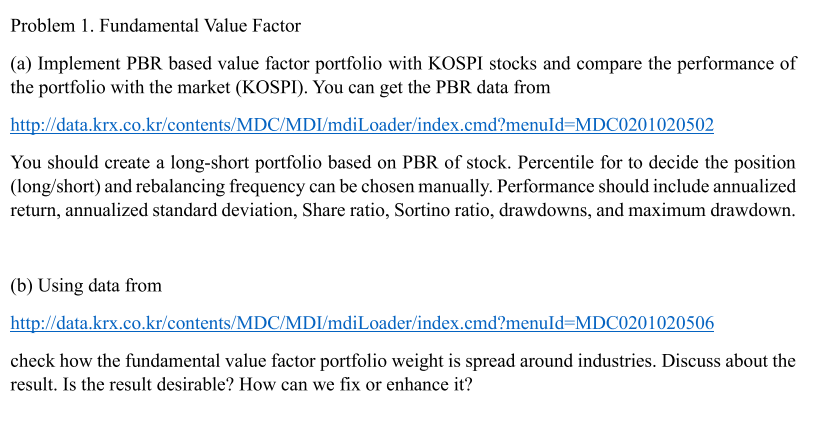

### Data 불러오기 

`pykrx` 라이브러리를 잘 연결해 기간을 입력받고 ii-di 2d matrix 를 데이터별로 불러올 수 있게 DM 형식으로 만들어보자. 

In [5]:
fromdate = '20200101'
todate = '20231031'

In [6]:
date_ts_list = krx.stock.get_previous_business_days(fromdate=fromdate, todate=todate)
date_list = [ts.strftime('%Y%m%d') for ts in  date_ts_list]

한 번이라도 KOSPI 안에 존재했던 종목은 모두 넣음

In [7]:
ii_universe = set()

for di in tqdm(date_list):
    di_snapshot = set(krx.stock.get_market_ticker_list(date=di, market='KOSPI'))
    ii_universe.update(di_snapshot)
    
    time.sleep(0.1)

  0%|          | 0/946 [00:00<?, ?it/s]

100%|██████████| 946/946 [05:24<00:00,  2.91it/s]


In [8]:
len(ii_universe)

989

`pykrx` 패키지를 의존성으로 하여, ii-di 형태의 2d matrix로 변환해서 받아올 수 있도록 wrapping만 함

이 때, 공통적인 로직은 `KRXdata` 클래스에 정의하고 개별 데이터마다 다른 함수 등등의 처리만 자식 클래스에서 처리

In [18]:
class KRXdata:
    def __init__(self, 
                 date_list, 
                 ) -> None:
        self.date_list = date_list

        self.available_cols = []
        self.di_snapshots = []

    def check_colname(self, colname):
        if colname not in self.available_cols:
            return False
        else:
            return True

    def get_available_cols(self):
        return self.available_cols

    def get_di_snapshot(self, di):
        return

    def collect_snapshots(self):
        return

    def merge_snapshots(self, colname):
        if not self.check_colname(colname):
            raise ValueError(f'colname {colname} is not available')
        
        di_datas = [snapshot[colname] for snapshot in self.di_snapshots]
        iidi_matrix = pd.concat(di_datas, axis=1)
        iidi_matrix.columns = self.date_list

        return iidi_matrix.T 

    def collect_snapshots(self):
        for di in tqdm(self.date_list):
            di_snapshot = self.get_di_snapshot(di)
            self.di_snapshots.append(di_snapshot)
            time.sleep(0.1)

        return

    def get_data(self, colname): # TODO: 이미 다운받았으면 다시 안받게 하기
        if not self.check_colname(colname):
            raise ValueError(f'colname {colname} is not available')
        
        iidi_matrix = self.merge_snapshots(colname)

        return iidi_matrix

In [10]:
class KRXmarcap(KRXdata):
    def __init__(self, 
                 date_list,
                 ) -> None:
        suPBR().__init__(date_list)
        self.collect_snapshots()
        self.available_cols = [
            '시가총액',
            '거래량',
            '거래대금',
            '상장주식수',
        ]
    
    def get_di_snapshot(self, di):
        di_snapshot = krx.stock.get_market_cap_by_ticker(date=di, market='ALL')

        return di_snapshot
        

In [11]:
class KRXohlcv(KRXdata):
    def __init__(self, 
                 date_list,
                 ) -> None:
        suPBR().__init__(date_list)
        self.collect_snapshots()
        self.available_cols = [
            '시가',
            '고가',
            '저가',
            '종가',
            '거래량',
            '거래대금',
            '등락률',
        ]
    
    def get_di_snapshot(self, di):
        di_snapshot = krx.stock.get_market_ohlcv(di, market='ALL')

        return di_snapshot
        

In [20]:
class KRXfunda(KRXdata):
    def __init__(self, 
                 date_list,
                 ) -> None:
        suPBR().__init__(date_list)
        self.collect_snapshots()
        self.available_cols = [
            'BPS',
            'PBR',
            'PBR',
            'EPS',
            'DIV',
            'DPS',
        ]
    
    def get_di_snapshot(self, di):
        di_snapshot = krx.stock.get_market_fundamental(di, market='ALL')

        return di_snapshot
        

In [12]:
close_df = KRXohlcv(date_list).get_data('종가')
close_df

100%|██████████| 946/946 [09:49<00:00,  1.60it/s]


티커,060310,095570,068400,006840,054620,265520,211270,027410,282330,138930,...,454910,443250,451220,289170,462020,445180,416180,351020,396470,432720
20200102,2795.0,5050.0,11800.0,34850.0,10400.0,34450.0,6970.0,5500.0,168500.0,7470.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20200103,2810.0,5100.0,11550.0,34950.0,10400.0,33750.0,7100.0,5560.0,169000.0,7490.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20200106,2685.0,5030.0,11300.0,34600.0,10200.0,33500.0,7010.0,5370.0,166500.0,7350.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20200107,2745.0,5030.0,11350.0,35300.0,9920.0,32950.0,7000.0,5500.0,169500.0,7430.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20200108,2585.0,4935.0,10950.0,33750.0,9780.0,32300.0,6810.0,5290.0,169500.0,7330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20231025,2215.0,3935.0,10800.0,17270.0,6370.0,17000.0,11570.0,3400.0,133100.0,7040.0,...,35100.0,14120.0,23650.0,3100.0,1984.0,12180.0,27600.0,NaN,NaN,NaN
20231026,2110.0,3850.0,10740.0,17320.0,6210.0,16610.0,11170.0,3265.0,131700.0,7000.0,...,33250.0,14050.0,21000.0,3335.0,1977.0,10880.0,26300.0,5700.0,8650.0,NaN
20231027,2090.0,3830.0,10500.0,18010.0,6100.0,16640.0,11330.0,3300.0,138600.0,6890.0,...,32300.0,15030.0,20200.0,2900.0,1963.0,10260.0,26100.0,5700.0,8860.0,20650.0
20231030,2140.0,3885.0,10300.0,17940.0,6030.0,16720.0,11750.0,3310.0,141300.0,6810.0,...,41150.0,14520.0,20350.0,2905.0,1959.0,11200.0,26950.0,5700.0,9030.0,20000.0


In [13]:
close_df.shape

(946, 2958)

In [14]:
return_df = close_df.pct_change(fill_method=None)

In [15]:
marcap_df = KRXmarcap(date_list).get_data('시가총액')
marcap_df

100%|██████████| 946/946 [09:19<00:00,  1.69it/s]


티커,005930,000660,005935,035420,207940,005380,012330,068270,051910,005490,...,454910,443250,451220,289170,462020,445180,416180,396470,351020,432720
20200102,3.295320e+14,6.894182e+13,3.752363e+13,3.007844e+13,2.835170e+13,2.521285e+13,2.358841e+13,2.310081e+13,2.216600e+13,2.057609e+13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20200103,3.313229e+14,6.879622e+13,3.756478e+13,2.991363e+13,2.792163e+13,2.478551e+13,2.382667e+13,2.277997e+13,2.195422e+13,2.066328e+13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20200106,3.313229e+14,6.865062e+13,3.760592e+13,2.974882e+13,2.725998e+13,2.478551e+13,2.377902e+13,2.220245e+13,2.167185e+13,2.014016e+13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20200107,3.331139e+14,6.843222e+13,3.809965e+13,3.082010e+13,2.772314e+13,2.467868e+13,2.406494e+13,2.284414e+13,2.195422e+13,2.022735e+13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20200108,3.390836e+14,7.090743e+13,3.842881e+13,3.016085e+13,2.702840e+13,2.393084e+13,2.335014e+13,2.220245e+13,2.131889e+13,1.987860e+13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20231025,4.059452e+14,9.282030e+13,4.509419e+13,3.102168e+13,5.145880e+13,3.849873e+13,2.083701e+13,2.197506e+13,3.233129e+13,3.767648e+13,...,2.275181e+12,1.548877e+11,1.862346e+11,1.088568e+10,8.620480e+09,2.042487e+11,2.494979e+11,NaN,NaN,NaN
20231026,3.981845e+14,8.736028e+13,4.443588e+13,2.984053e+13,5.188585e+13,3.796991e+13,2.036558e+13,2.191649e+13,3.007234e+13,3.564677e+13,...,2.155264e+12,1.541199e+11,1.653668e+11,1.171088e+10,8.590065e+09,1.824488e+11,2.377462e+11,1.394380e+11,1.182750e+10,NaN
20231027,4.017664e+14,8.670508e+13,4.410673e+13,3.041470e+13,5.145880e+13,3.714493e+13,2.074272e+13,2.188721e+13,3.095474e+13,3.577363e+13,...,2.093685e+12,1.648699e+11,1.590671e+11,1.018338e+10,8.529235e+09,1.720519e+11,2.359382e+11,1.428232e+11,1.182750e+10,2.104962e+11
20231030,4.017664e+14,8.670508e+13,4.427130e+13,3.052953e+13,5.131645e+13,3.648918e+13,1.994130e+13,2.185793e+13,3.141359e+13,3.661934e+13,...,2.667342e+12,1.592755e+11,1.602483e+11,1.020093e+10,8.511855e+09,1.878149e+11,2.436220e+11,1.455636e+11,1.182750e+10,2.038704e+11


In [44]:
PBR_df = KRXfunda(date_list).get_data('PBR')

100%|██████████| 946/946 [11:15<00:00,  1.40it/s]  


In [45]:
PBR_df.shape

(946, 2730)

In [46]:
# universe
sid_list = list(set(marcap_df.columns) & set(PBR_df.columns) & set(return_df.columns))
len(sid_list)

2730

In [47]:
return_df = return_df.loc[:, sid_list].copy()
marcap_df = marcap_df.loc[:, sid_list].copy()
PBR_df = PBR_df.loc[:, sid_list].copy()

In [73]:
return_df.to_pickle('return_df.pkl')
marcap_df.to_pickle('marcap_df.pkl')
PBR_df.to_pickle('PBR_df.pkl')

In [ ]:
return_df = pd.read_pickle('return_df.pkl')
marcap_df = pd.read_pickle('marcap_df.pkl')
PBR_df = pd.read_pickle('PBR_df.pkl')

### PBR factor portfolio

- long-short portfolio
- rebalance daily


반으로 나눠 value는 long, growth는 short한다. 

1. 동일 가중으로 했을 경우와 (rank)
2. PBR의 값에 따라 평균의 편차로 크기를 정했을 경우 (demeaned signal)

#### 1. 동일 가중 (rank)

In [48]:
def is_value(pbr_row: pd.Series): # = High Value = low PBR
    rank_threshold = len(pbr_row[~pbr_row.isna()]) * 1/2
    value_threshold = pbr_row.nsmallest(int(rank_threshold))
    selections = value_threshold.index

    return selections # 오직 high 에 해당하는 종목들의 index만 줌. 
    

In [49]:
def is_growth(pbr_row: pd.Series): # = Low Value = high PBR
    rank_threshold = len(pbr_row[~pbr_row.isna()]) * 1/2
    value_threshold = pbr_row.nlargest(int(rank_threshold))
    selections = value_threshold.index

    return selections
    

In [50]:
value_df = PBR_df.apply(lambda row: row[is_value(row)], axis=1)
value_returns = return_df[~value_df.isna()]
value_portfolio_returns = value_returns.mean(axis=1)

In [51]:
growth_df = PBR_df.apply(lambda row: row[is_growth(row)], axis=1)
growth_returns = return_df[~growth_df.isna()]
growth_portfolio_returns = growth_returns.mean(axis=1)

In [52]:
value_longshort_returns = value_portfolio_returns - growth_portfolio_returns

In [53]:
def to_dateindex(series, format='%Y%m%d'):
    dateindex = pd.to_datetime(series.index, format=format)
    series.index = dateindex

    return series

                    Strategy
------------------  ----------
Start Period        2020-01-03
End Period          2023-10-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   17.54%
CAGR﹪              2.96%

Sharpe              0.31
Prob. Sharpe Ratio  72.05%
Sortino             0.4
Sortino/√2          0.28
Omega               1.06

Max Drawdown        -42.53%
Longest DD Days     847

Gain/Pain Ratio     0.06
Gain/Pain (1M)      0.22

Payoff Ratio        0.79
Profit Factor       1.06
Common Sense Ratio  0.87
CPC Index           0.48
Tail Ratio          0.82
Outlier Win Ratio   3.72
Outlier Loss Ratio  3.77

MTD                 -4.67%
3M                  -4.69%
6M                  -10.4%
YTD                 -7.78%
1Y                  -2.94%
3Y (ann.)           -0.33%
5Y (ann.)           2.96%
10Y (ann.)          2.96%
All-time (ann.)     2.96%

Avg. Drawdown       -4.41%
Avg. Drawdown Days  41
Recovery Factor     0.6
Ulcer Index         0.19
Serenity Index      0.06


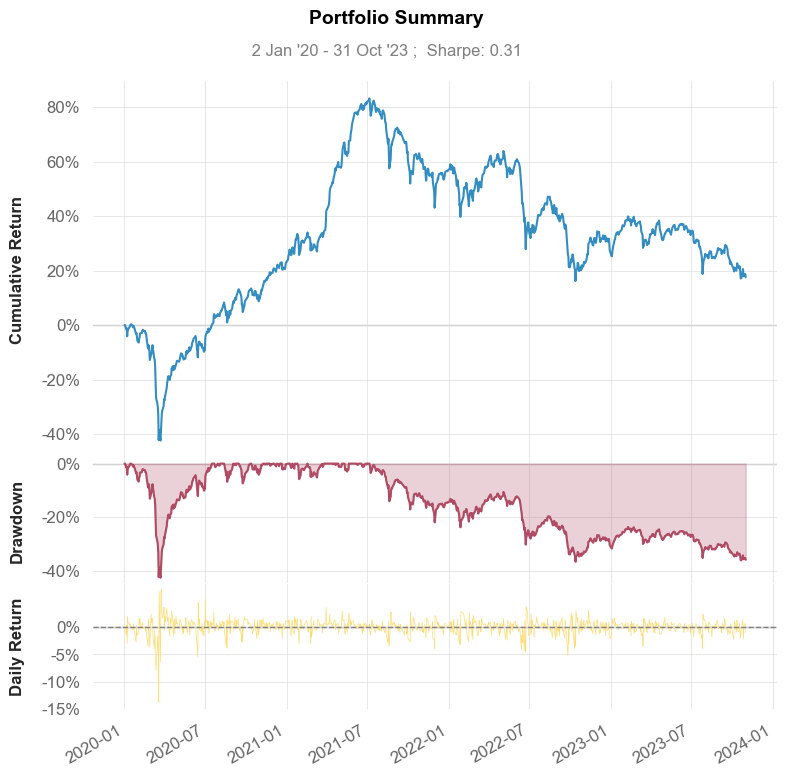

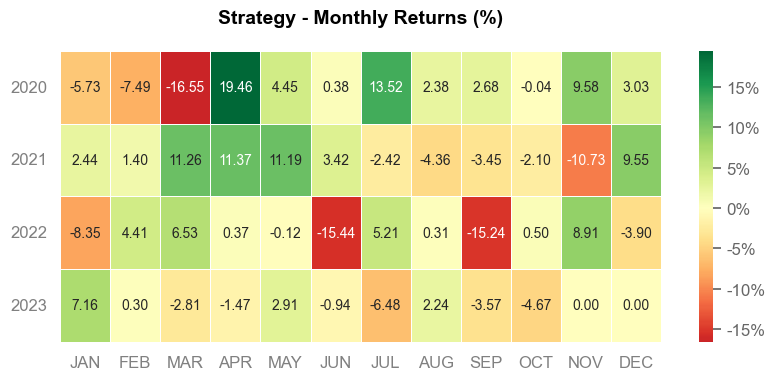

In [54]:
qs.reports.basic(to_dateindex(value_portfolio_returns))

#### 2. PBR size (signal demean)

In [56]:
demeaned_PBR_df = PBR_df.sub(PBR_df.mean(axis=1), axis=0)

shift 하냐 안하냐 차이가 완전 반대로 나옴. 

shift 안하면 수익률 600%에 sharpe 1.89나옴. 

shift 해줘서 날짜 맞추면 바로 바닥으로...

In [70]:
demeaned_PBR_longshort_returns = demeaned_PBR_df.shift(1) * return_df
demeaned_PBR_longshort_returns = demeaned_PBR_longshort_returns.mean(axis=1)

                    Strategy
------------------  ----------
Start Period        2020-01-03
End Period          2023-10-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   -87.86%
CAGR﹪              -31.64%

Sharpe              -1.8
Prob. Sharpe Ratio  0.04%
Sortino             -2.43
Sortino/√2          -1.72
Omega               0.71

Max Drawdown        -89.21%
Longest DD Days     1265

Gain/Pain Ratio     -0.29
Gain/Pain (1M)      -0.65

Payoff Ratio        0.94
Profit Factor       0.71
Common Sense Ratio  0.54
CPC Index           0.29
Tail Ratio          0.76
Outlier Win Ratio   5.52
Outlier Loss Ratio  4.09

MTD                 -21.68%
3M                  -38.92%
6M                  -33.88%
YTD                 -25.63%
1Y                  -29.06%
3Y (ann.)           -35.57%
5Y (ann.)           -31.64%
10Y (ann.)          -31.64%
All-time (ann.)     -31.64%

Avg. Drawdown       -11.59%
Avg. Drawdown Days  152
Recovery Factor     2.19
Ulcer Index         0.66
Se

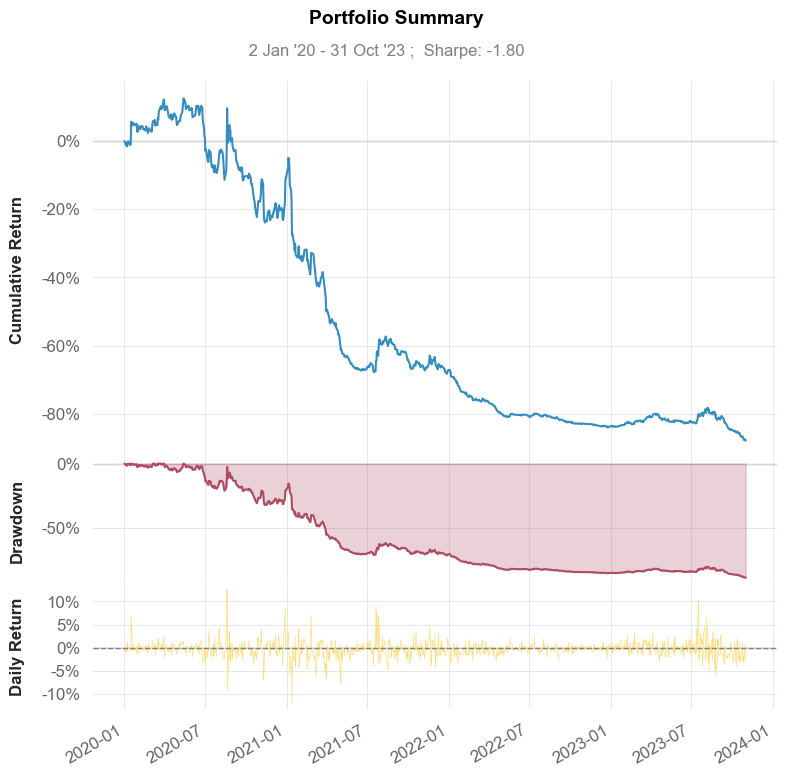

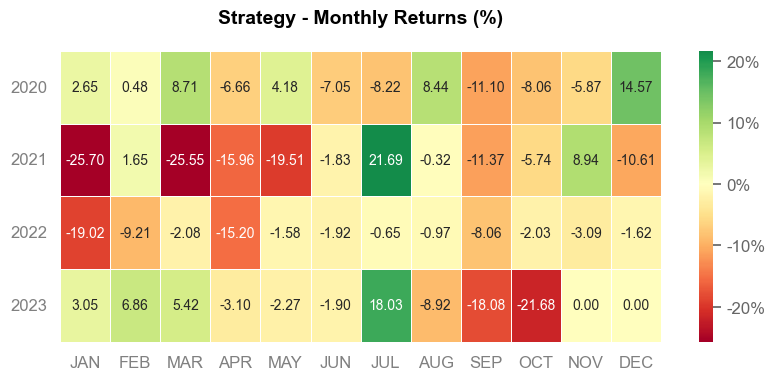

In [71]:
qs.reports.basic(to_dateindex(demeaned_PBR_longshort_returns))

## Q2. Custom Strategy

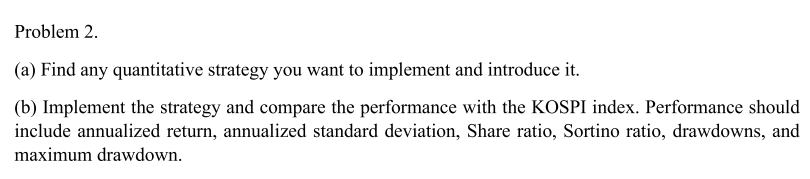

In [81]:
yf.downlo

yfinance.Ticker object <^KS11>